In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.callbacks import TensorBoard
import time
import zipfile

from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt

# For nice Plots
%matplotlib inline
plt.style.use('default')

# 1. Download data and convert to png files

In [2]:
setup_data = False
if setup_data:
    !wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
    zipfile.ZipFile('UCMerced_LandUse.zip', 'r').extractall()
    
    def find_tif_files(directory):
        tif_files = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(".tif"):
                    tif_files.append(os.path.join(root, file))
        return tif_files

    directory_to_search = "UCMerced_LandUse"
    tif_files = find_tif_files(directory_to_search)

    # Convert tif files to png
    for tif_file in tif_files:
        # Open the tif file
        tiff_image = Image.open(tif_file)
        # Convert the TIFF image to RGB if it's not already in RGB format
        if tiff_image.mode != "RGB":
            tiff_image = tiff_image.convert("RGB")
        # Save the TIFF image as PNG
        png_image_path = tif_file.replace('.tif','.png')
        tiff_image.save(png_image_path, format="PNG")

In [3]:
# build data from directories of images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
dataset = keras.utils.image_dataset_from_directory('UCMerced_LandUse/Images', labels='inferred')

Found 2101 files belonging to 21 classes.


# 2. Preview Data

In [4]:
class_names = dataset.class_names
nClasses = len(class_names)
print('Class names: ')
print(class_names)

Class names: 
['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


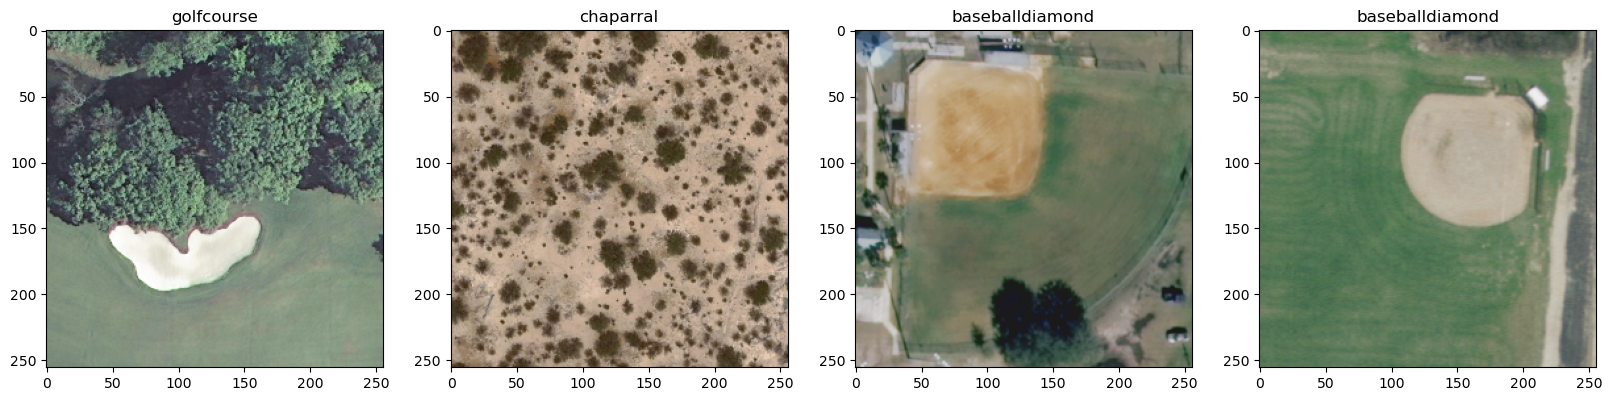

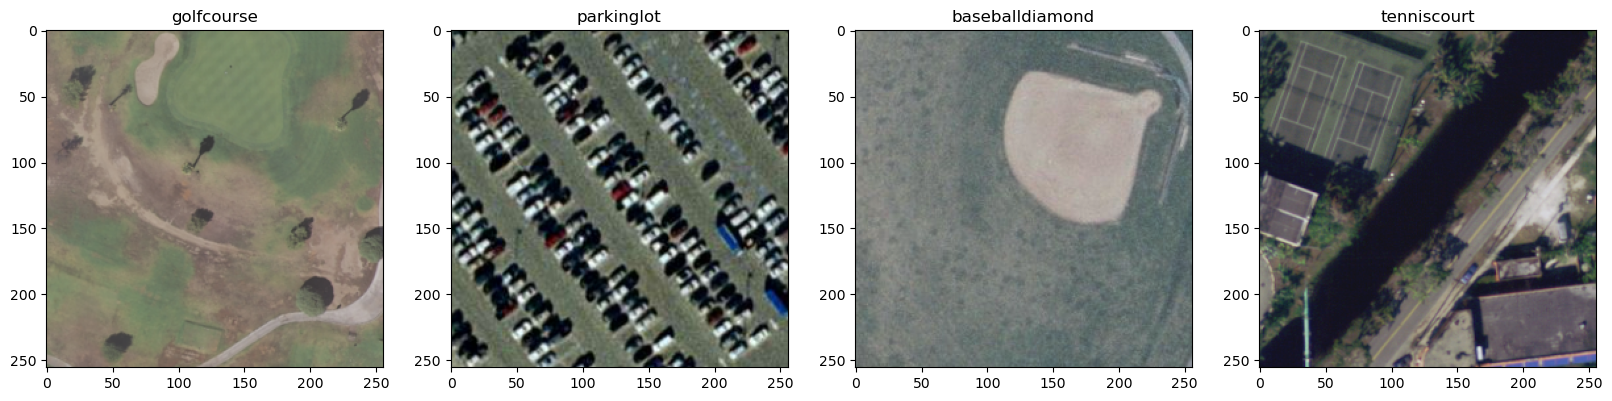

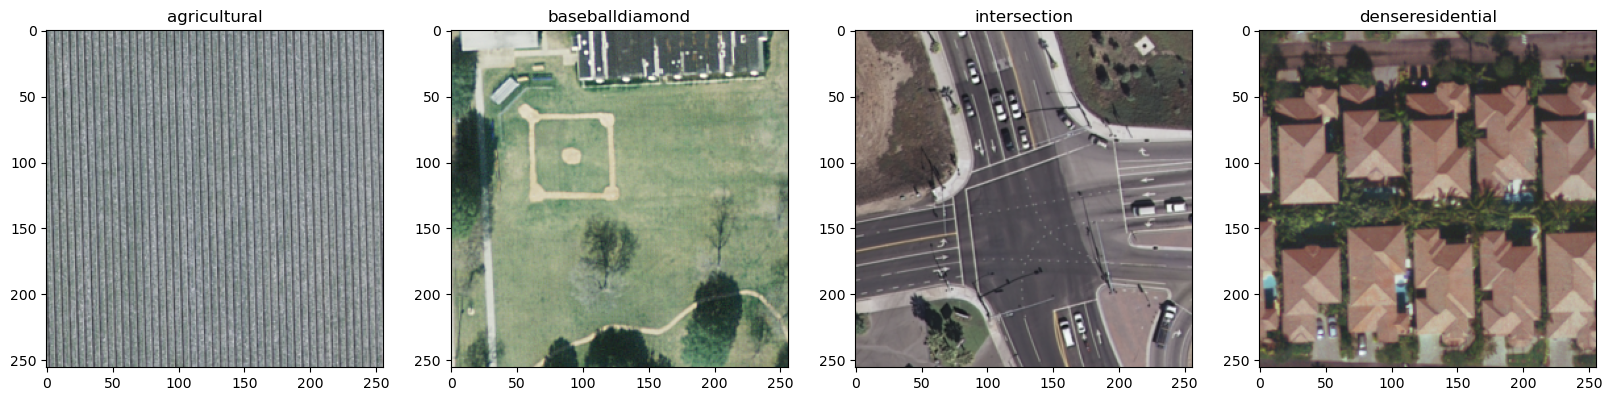

In [5]:
# plot some images from the classes
data_iterator = dataset.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_names[batch[1][idx]])
    
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][4:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_names[batch[1][4+idx]])
    
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][8:12]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_names[batch[1][8+idx]])

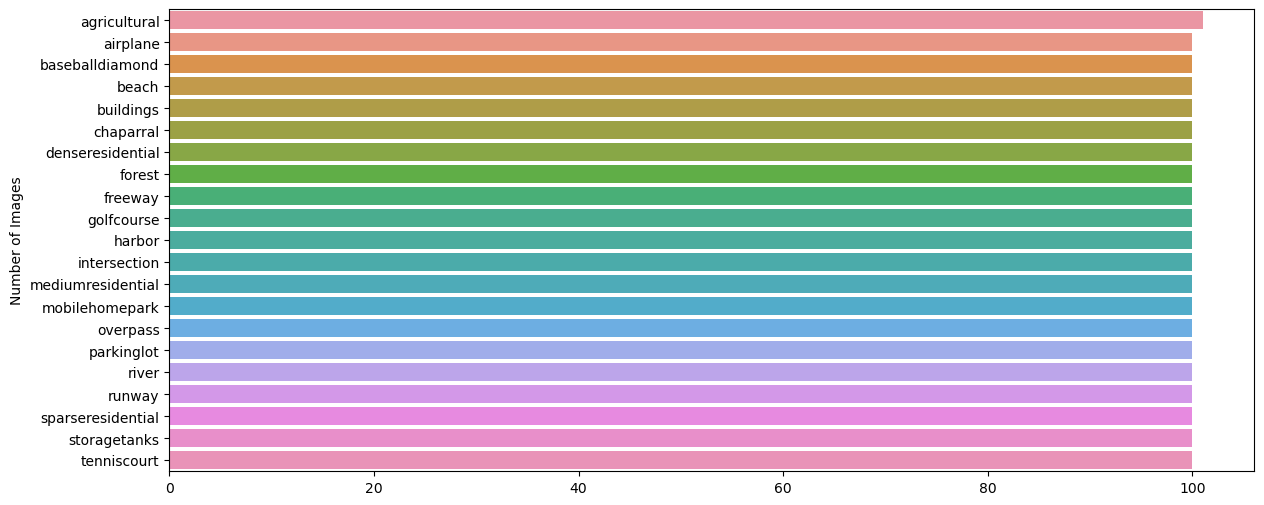

In [6]:
# determine the number of images per class
counts = np.zeros(nClasses)
for x, y in dataset:
    for i in y.numpy():
        counts[i] = counts[i] + 1

plt.figure(figsize=(14, 6))
plt.ylabel('Class Label')
plt.ylabel('Number of Images')
class_counts = sns.barplot(x = counts , y = class_names) 

# 3. Scale Data

In [7]:
dataset = dataset.map(lambda x,y: (x/255, y))

In [8]:
# check that the data is on a 0-1 scale
dataset.as_numpy_iterator().next()

(array([[[[0.4627451 , 0.5019608 , 0.56078434],
          [0.4745098 , 0.5137255 , 0.5764706 ],
          [0.5176471 , 0.5647059 , 0.6039216 ],
          ...,
          [0.41568628, 0.35686275, 0.32156864],
          [0.42745098, 0.37254903, 0.33333334],
          [0.39607844, 0.3372549 , 0.3019608 ]],
 
         [[0.49019608, 0.5372549 , 0.5921569 ],
          [0.54509807, 0.6       , 0.6509804 ],
          [0.49411765, 0.54509807, 0.58431375],
          ...,
          [0.5254902 , 0.45882353, 0.4509804 ],
          [0.5529412 , 0.49019608, 0.48235294],
          [0.5019608 , 0.44313726, 0.43137255]],
 
         [[0.5568628 , 0.60784316, 0.6509804 ],
          [0.49803922, 0.5372549 , 0.57254905],
          [0.5254902 , 0.56078434, 0.60784316],
          ...,
          [0.5529412 , 0.56078434, 0.5058824 ],
          [0.5372549 , 0.54901963, 0.49803922],
          [0.5647059 , 0.5686275 , 0.53333336]],
 
         ...,
 
         [[0.49019608, 0.49803922, 0.5294118 ],
          [0.48627

# 4. Split Data

In [9]:
train_size = int(len(dataset)*.7)
val_size = int(len(dataset)*.2)
test_size = int(len(dataset)*.1)

In [10]:
train_size

46

In [11]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

# 5. Method 1: Using Tensorboard and Sequential

In [12]:
classifier = Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(256,256,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2)) #if stride not given it equal to pool filter size
classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
classifier.add(Flatten())
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=nClasses,activation='softmax'))
adam = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam'
)
classifier.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
tensorboard = TensorBoard()

In [14]:
#%%capture
hist = classifier.fit_generator(train,
                        epochs = 50,
                        validation_data = test,
                        validation_steps = 20, 
                        callbacks=[tensorboard]
                        );

#Some Helpful Instructions:

#finetune you network parameter in last by using low learning rate like 0.00001
#classifier.save('resources/dogcat_model_bak.h5')
#from tensorflow.keras.models import load_model
#model = load_model('partial_trained1')
#100 iteration with learning rate 0.001 and after that 0.0001

Epoch 1/50
46/46 [==============================] - 34s 736ms/step - loss: 0.6227 - accuracy: 0.8553
Epoch 2/50
46/46 [==============================] - 34s 725ms/step - loss: 0.3080 - accuracy: 0.9198
Epoch 3/50
46/46 [==============================] - 34s 728ms/step - loss: 0.1914 - accuracy: 0.9531
Epoch 4/50
46/46 [==============================] - 33s 722ms/step - loss: 0.1218 - accuracy: 0.9755
Epoch 5/50
46/46 [==============================] - 34s 735ms/step - loss: 0.1798 - accuracy: 0.9592
Epoch 6/50
46/46 [==============================] - 34s 728ms/step - loss: 0.0966 - accuracy: 0.9796
Epoch 7/50
46/46 [==============================] - 34s 727ms/step - loss: 0.0524 - accuracy: 0.9844
Epoch 8/50
46/46 [==============================] - 34s 738ms/step - loss: 0.0885 - accuracy: 0.9857
Epoch 9/50
46/46 [==============================] - 34s 730ms/step - loss: 0.0370 - accuracy: 0.9939
Epoch 10/50
46/46 [==============================] - 34s 728ms/step - loss: 0.0226 - accura

In [ ]:
 def plot_metrics(history, class_names):
    # percision = fraction of predicted 'trues' that are correct
    # recall = fraction of 'trues' that were found
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
    ls = ['-','--','.']
    j = 0
    for hist in history:
        metric_names = list(hist.history.keys())
        for idx in range(2):
            ax[0,idx].plot(hist.history[metric_names[idx]], color='teal', linestyle=ls[j], label=metric_names[idx])
            ax[0,idx].plot(hist.history['val_'+metric_names[idx]], color='orange', linestyle=ls[j], label='val_'+metric_names[idx])
            ax[0,idx].set_title(metric_names[idx], fontsize=10)
            ax[0,idx].legend()
        for idx in range(2):
            ax[1,idx].plot(hist.history[metric_names[idx+2]], color='teal', linestyle=ls[j], label=metric_names[idx+2])
            ax[1,idx].plot(hist.history['val_'+metric_names[idx+2]], color='orange', linestyle=ls[j], label='val_'+metric_names[idx+2])
            ax[1,idx].set_title(metric_names[idx+2], fontsize=10)
            ax[1,idx].legend()
        j = j + 1
    fig.suptitle('Evaluation Metrics - '+class_names[0]+' vs '+class_names[1], fontsize=20)

In [ ]:
plot_metrics([hist], class_names)

# 6. Build Deep Learning Model

In [ ]:
n_epochs = 8

In [ ]:
train

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(nClasses, activation='softmax'))

In [ ]:
model.compile('adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
model.summary()

# 7. Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=n_epochs, validation_data=val, callbacks=[tensorboard_callback])

# 8. Plot Performance

In [ ]:
plot_metrics([hist], class_names)

In [ ]:
# save the history from validating this model for future comparison
base_model_hist = hist

# 9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

# 10. Test

In [ ]:
import cv2

In [ ]:
img = 255-cv2.imread(data_dir+'/minivan/2015-toyota-sienna-front-right.jpg')
#img = cv2.cvtColor(255-img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
print(yhat)

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Minivan')
else:
    print(f'Predicted class is Ferrari')

# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
mode_fname = os.path.join('models','imageclassifier.h5')
model.save(mode_fname)

In [ ]:
new_model = load_model(mode_fname)

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

# Regularization

In [ ]:
model = Sequential()
# see: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
# see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2
model.add(Conv2D(16, (3,3), 1, activation='elu', input_shape=(256,256,3),
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='elu',
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='elu',
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='elu'))
model.add(Dense(nClasses, activation='sigmoid'))
model.compile(optimizer="nadam",
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
# loss="sparse_categorical_crossentropy"
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
hist = model.fit(train, epochs=n_epochs, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
plot_metrics([base_model_hist, hist], class_names)

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[256, 256]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(nClasses, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

# Test the regularized model

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

# Try Resnet from https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435